# SNAP

The Supplemental Nutrition Assistance Program (SNAP) is a program that provides food assistance to low-income families.
Eligibility depends on household size, state, and income, before and after a series of deductions involving earnings and various costs such as shelter and childcare.

## Examples

### How earnings affect a one-person household's SNAP benefits

Consider a single person household in California with \$1,000 monthly earned income and \$500 monthly rent.
They would be eligible for \$69 per month in SNAP benefits.

In [1]:
from openfisca_us import IndividualSim
import pandas as pd
import plotly.express as px

sim = IndividualSim(year=2022)
sim.add_person(name="person", market_income=1000 * 12)
sim.add_spm_unit(name="spm_unit", members=["person"], housing_cost=500 * 12)

sim.calc("snap") / 12

array([69.149994], dtype=float32)

What if their earnings change? They receive the maximum benefit of \$2,448 per year (\$204 per month) until they reach \$7,500 in annual earnings, at which point it starts phasing out until their earnings reach about \$14,000.

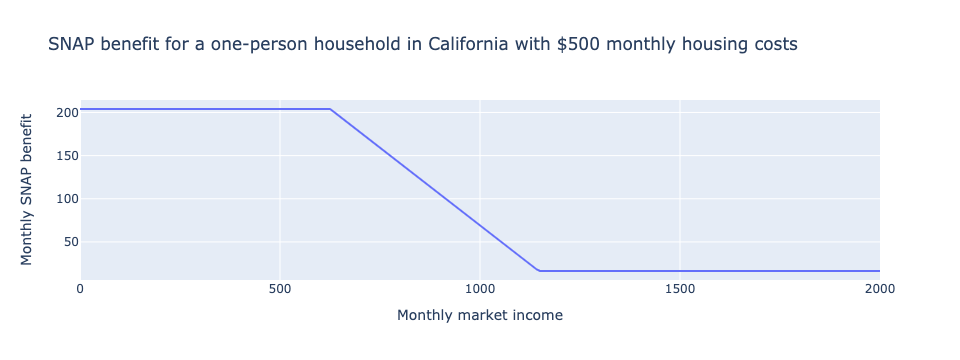

In [2]:
sim.vary("market_income", max=2000 * 12)

import plotly.express as px

LABELS = dict(
    market_income="Monthly market income",
    housing_cost="Monthly housing cost",
    snap="Monthly SNAP benefit",
    mtr="Marginal tax rate",
    housing_subsidy_rate="Housing subsidy rate"
)

df = pd.DataFrame(dict(
    market_income=sim.calc("market_income")[0] / 12,
    snap = sim.calc("snap")[0] / 12,
    mtr = -sim.deriv("snap", "market_income")
))

px.line(df, "market_income", "snap", labels=LABELS,
    title="SNAP benefit for a one-person household in California with $500 monthly housing costs")

We can also view their marginal tax rate from the program, revealing that SNAP phases out at 36 cents on the dollar through the phase-out region.

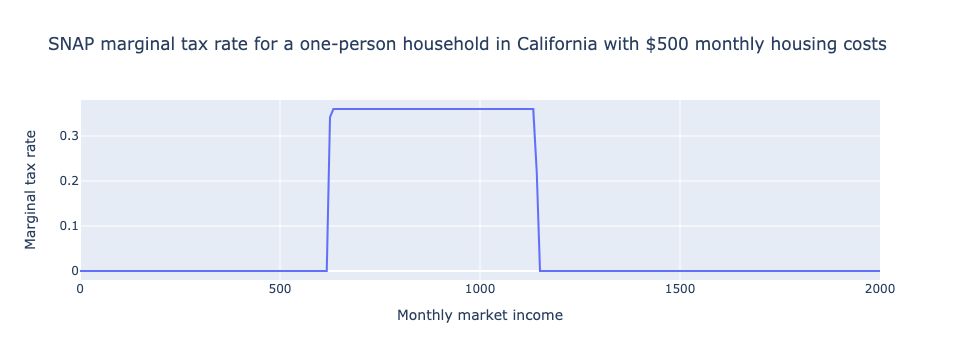

In [3]:
px.line(df, "market_income", "mtr", labels=LABELS,
    title="SNAP marginal tax rate for a one-person household in California with $500 monthly housing costs")

### How housing costs affect a four-person household's SNAP benefits

We can also visualize how other household characteristics affect SNAP benefits.
For example, what if we vary the housing costs of a four-person household with \$2,000 monthly income?

Their SNAP benefit is \$254 per month if their housing costs are less than \$700 per month. If they spend \$1,300 per month on housing, their benefit rises 70% for \$433 per month.

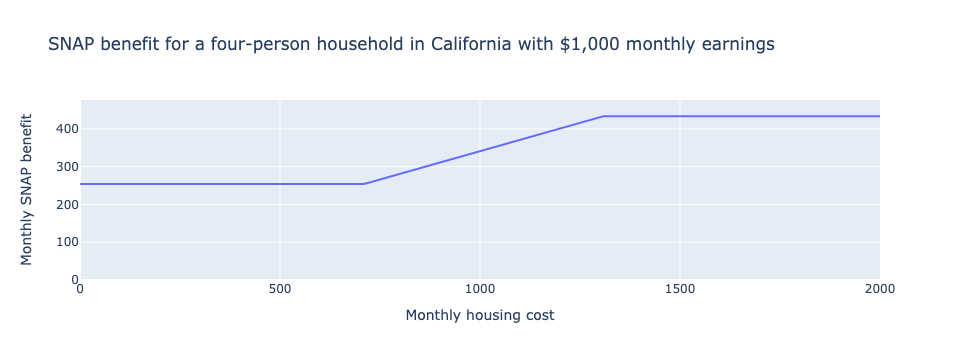

In [4]:
sim = IndividualSim(year=2022)
sim.add_person(name="parent1", market_income=1000 * 12)
sim.add_person(name="parent2", market_income=1000 * 12)
sim.add_person(name="child1")
sim.add_person(name="child2")
sim.add_spm_unit(name="spm_unit", members=["parent1", "parent2", "child1", "child2"], housing_cost=500 * 12)

sim.vary("housing_cost", max=2000 * 12)

df = pd.DataFrame(dict(
    housing_cost=sim.calc("housing_cost")[0] / 12,
    snap = sim.calc("snap")[0] / 12,
    housing_subsidy_rate = sim.deriv("snap", "housing_cost")
))


fig = px.line(df, "housing_cost", "snap", labels=LABELS,
    title="SNAP benefit for a four-person household in California with $1,000 monthly earnings")
fig.update_layout(yaxis_range=[0, df.snap.max() * 1.1])
fig.show()

As before, we can also see the rate at which SNAP increases with housing costs. For this household, SNAP subsidizes housing costs at a rate of 30% for housing costs ranging from \$700 to \$1,300 per month.

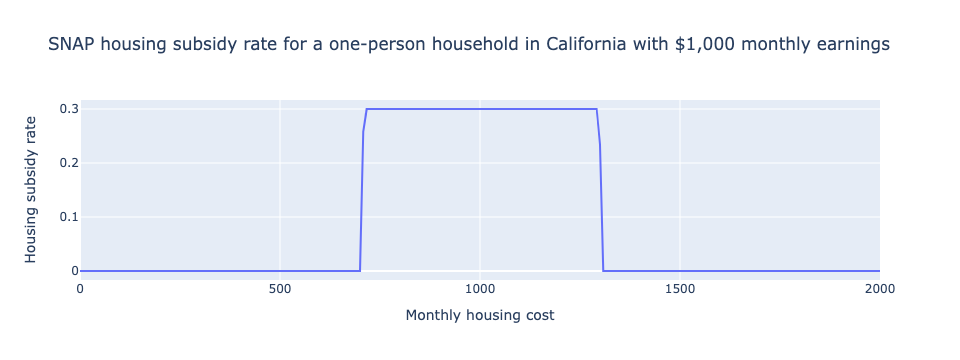

In [5]:
px.line(df, "housing_cost", "housing_subsidy_rate", labels=LABELS,
    title="SNAP housing subsidy rate for a one-person household in California with $1,000 monthly earnings")